## Introduction

The Coronavirus of 2020, otherwise known as COVID-19, remains a present in the present day despite several efforts to contain the virus in recent times. At this point it is going to remain ever present in our current world just like virulent flu. To diagnose COVID-19, there are some telling symptoms such as the loss of the smell or taste, the feeling that your mind is hazy, and the difficulty in breathing. The symptom can be also be seen in the x-ray images of the lungs as they can often cause scarring to occur in the lungs. This can be used to help differentiate people who have COVID-19 or not. 

This notebook will thus aim to create a convolutional neural network that takes an input, an x-ray image of the lung, and tries to classify it as either having COVID or being a normal image. A convolutional neural network is an artificial neural network that takes image inputs and, put it simply, scans the image and tries to figure out what it is. The CNN is able to learn to classify images through training it against other images. In this case the CNN will be trained against a control, i.e. normal x-ray images of the lungs. So, to reiterate, the goal of this notebook will be to classify COVID x-ray images of the lung versus normal lung images using a convolutional neural network. 

The image data set to be used for training and testing is provided through Kaggle at this link [here](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset). The image dataset is split into 2 major folders, one for training and one for testing. Within each folder there are 3 folders with images corresponding to COVID, normal and pneumonia. For this notebook, we are going to not use the images from the pneumonia folder and will be making a binary classification between COVID and normal lungs. 

## Resources
- https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
- https://www.tensorflow.org/api_docs/python/tf/image/crop_to_bounding_box
- https://www.tensorflow.org/api_docs/python/tf/image/rgb_to_grayscale
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
- https://iq.opengenus.org/vgg19-architecture/

## Initial Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix

In [2]:
TRAIN_PATH = './Covid19-dataset/train/'
TEST_PATH = './Covid19-dataset/test/'

NORMAL = 'Normal/'
COVID = 'Covid/'

In [3]:
# read file names
normal_train = os.listdir(TRAIN_PATH + NORMAL)
print("number of normal images:", len(normal_train))

covid_train = os.listdir(TRAIN_PATH + COVID)
print("number of covid images:", len(covid_train))

number of normal images: 70
number of covid images: 111


Because the images are in different folders, we are going to add them into a dataframe with the file path to locate them. This is just for ease of access when trying to look for images.

In [4]:
# create dataframe with normal images and labelling them as 0
train_normal = pd.DataFrame(list(zip(normal_train, np.zeros(len(normal_train)))), columns=['image', 'label'])
# create dataframe with covid images and labelling as 1
train_covid = pd.DataFrame(list(zip(covid_train, np.ones(len(covid_train)))), columns=['image', 'label'])

# the file names overlap so added the folder it belongs to before the name to differentiate
train_normal.image = NORMAL + train_normal.image
train_covid.image = COVID + train_covid.image

In [5]:
# concatentating and shuffling the rows to make the train image data set
train = pd.concat([train_normal, train_covid]).sample(frac=1, random_state=12).reset_index(drop=True)
train.label = train.label.astype(int)
train.label = train.label.astype(str)

In [6]:
train.head()

,image,label
0,Covid/045.jpeg,1
1,Covid/079.jpeg,1
2,Covid/COVID-00026.jpg,1
3,Normal/074.jpeg,0
4,Covid/COVID-00028.jpg,1


In [7]:
# create the test set the same way
normal_test = os.listdir(TEST_PATH + NORMAL)
covid_test = os.listdir(TEST_PATH + COVID)

test_normal = pd.DataFrame(list(zip(normal_test, np.zeros(len(normal_test)))), columns=['image', 'label'])
test_covid = pd.DataFrame(list(zip(covid_test, np.ones(len(covid_test)))), columns=['image', 'label'])

test_normal.image = NORMAL + test_normal.image
test_covid.image = COVID + test_covid.image

# concatentating and shuffling the rows to make the test image data set
test = pd.concat([test_normal, test_covid]).sample(frac=1, random_state=12).reset_index(drop=True)
test.label = test.label.astype(int)
test.label = test.label.astype(str)

In [8]:
test.head()

,image,label
0,Covid/auntminnie-c-2020_01_28_23_51_6665_2020_...,1
1,Covid/COVID-00022.jpg,1
2,Normal/0109.jpeg,0
3,Covid/auntminnie-b-2020_01_28_23_51_6665_2020_...,1
4,Covid/094.png,1


Just a side note, I honestly don't know why there are different naming conventions for the images though.

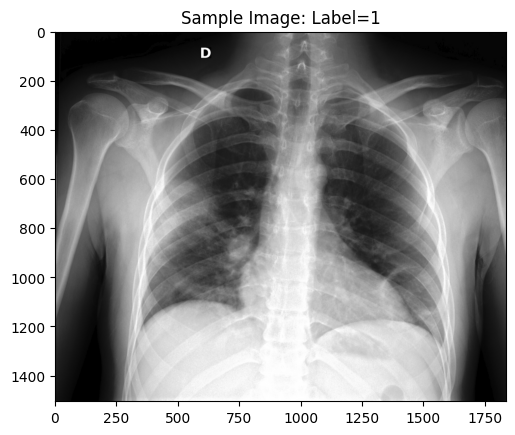

In [9]:
img = np.asarray(Image.open(TRAIN_PATH + train.image[0]))
plt.imshow(img)
plt.title(f'Sample Image: Label={train.label[0]}')
plt.show()

In [10]:
img.shape

(1505, 1837, 3)

The x-ray images have 3 channels, which means its in the form of an RGB image. To make it easier, and since they are all x-ray images, we are going to change these images to have only 1 channel - making the images black and white. 

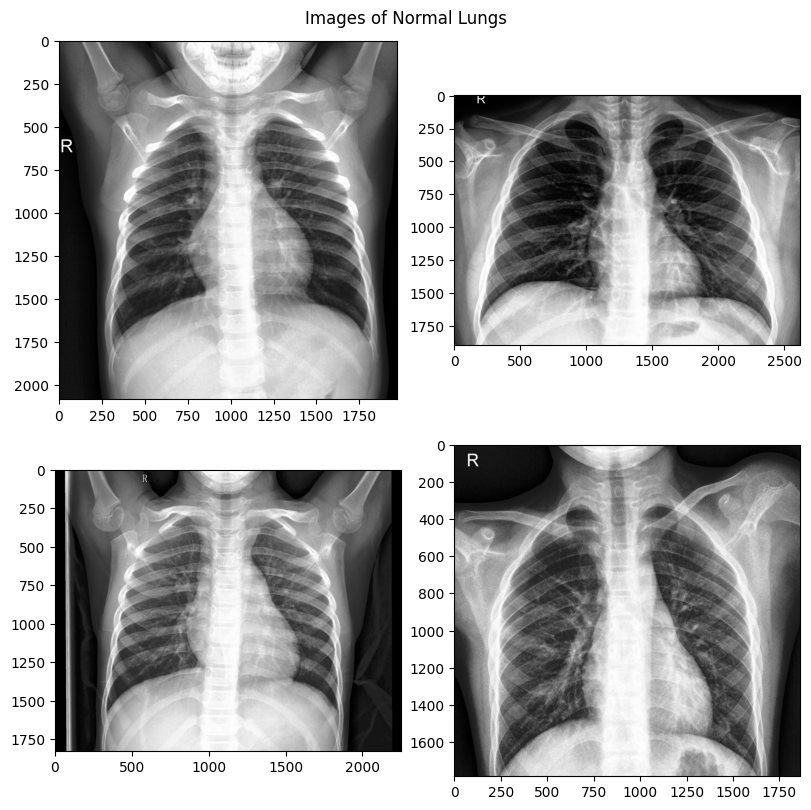

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), layout='constrained')

for i in range(4):
    img = np.asarray(Image.open(TRAIN_PATH + train[train.label == '0'].image.iloc[i]))
    ax[i//2, i%2].imshow(img)
plt.suptitle('Images of Normal Lungs')
plt.show()

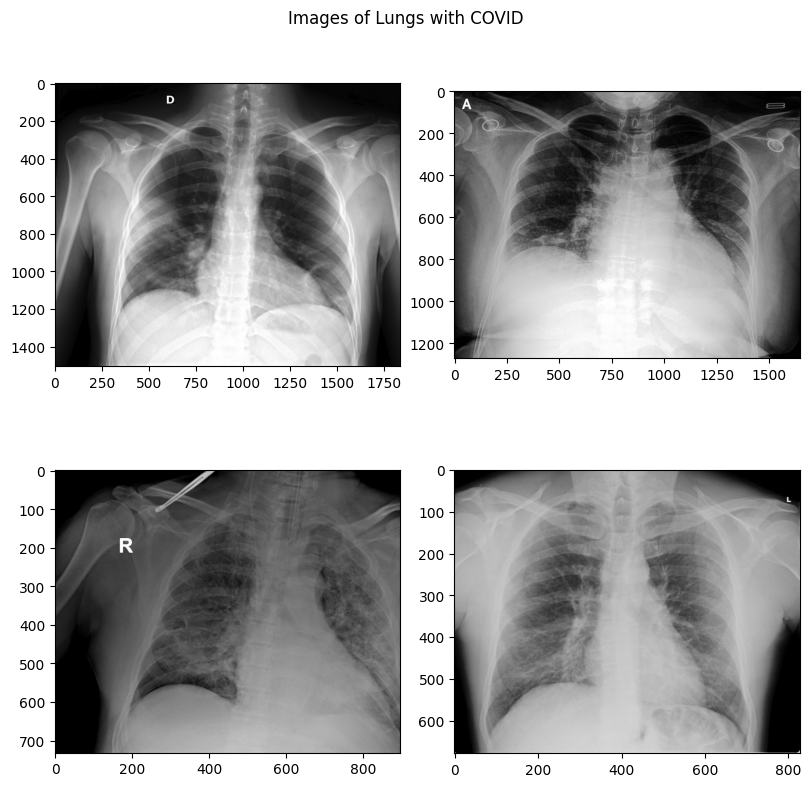

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), layout='constrained')

for i in range(4):
    # the .convert method is to show the image in grayscale since it may appear with color
    img = Image.open(TRAIN_PATH + train[train.label == '1'].image.iloc[i]).convert('LA')
    ax[i//2, i%2].imshow(img)
plt.suptitle('Images of Lungs with COVID')
plt.show()

Something to note here is that the images are all different sizes. Before we give these images as inputs into our model we would have to determine how we are going to normalize these images, making them all the same size. 

Alas, I am no medical expert so I cannot deduce exactly what the difference is between the normal lungs and the COVID lungs. If I had to take a guess, the lungs with COVID look more cloudy when seen on x-rays.

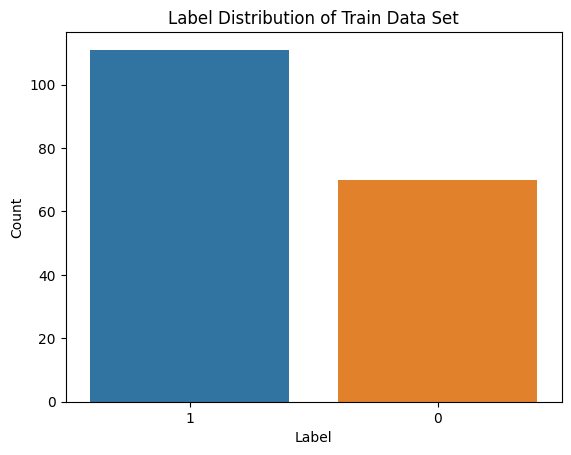

In [13]:
label_count = train.label.value_counts()
sns.barplot(x = label_count.index, y = label_count[:])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution of Train Data Set')
plt.show()

We already saw that there were around 200 total images and that there are more images of COVID than the normal lungs when we examine the image files earlier. Looking at the bar plot here, we see that there is no large discrepancy between the two labels, so we are going to proceed with the preprocessing. 

## Preprocessing

We have some options on how we want to proceed with the preprocessing here. First though we need to make sure the images are turned into black and white images by making it have one color channel (ex. (height, width, #channel) -> (height, width, 1)). We can then choose to resize the images to one size. Normally I would have done this, but I wanted to try cropping the image first and then resizing. The reason is because I hoped to preserve minute details this way since resizing the entire image can diminsh or wipe those features away and also because I wanted to try playing with the image.

Thus, below is a custom function that takes an image that was opened through the PIL.Image method and checks the image's shape for the color channel changes. Since some images apparently didn't have a 3rd dimension - the color channel, the function reshapes it and adds a 1 on that dimension. The initial image cropping was done based on a portion of the image instead of a strict number. This means that instead of starting from a height of 100px and width of 200px (the crop starts at the top left of the image) and taking a square crop of the same distance down and right, a crop is taken starting from 1/6 of the original image height and 1/7 of the original image width whatever it may be and subtracting the original image size from that offset to find where to end the crop. This is because the images are all different sizes so a strict crop may miss the image. Since the lungs are more or less in the center, this sort of portion cropping seemed to work fine. The resizing it then made with padding to a 224 x 224 pixel image which is going to be our image size for all image.

In [14]:
def preprocess(image):
    
    img = np.asarray(image)
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # check shape of image since
    if len(img.shape) < 3:
        img = np.reshape(img, (img_height, img_width, 1))
    
    if img.shape[2] == 3:
        # convert from rgb to grayscale
        img = tf.image.rgb_to_grayscale(np.asarray(image))
    
    OFFSET_HEIGHT = img_height // 6 
    OFFSET_WIDTH = img_width // 7
    TARGET_WIDTH = img_width - (OFFSET_WIDTH * 2)
    TARGET_HEIGHT = img_height - (OFFSET_HEIGHT * 2)
    
    output = tf.image.crop_to_bounding_box(img, OFFSET_HEIGHT, OFFSET_WIDTH, 
                                           TARGET_HEIGHT, TARGET_WIDTH)
#     output = tf.image.central_crop(img, 0.6)
    output = tf.image.resize_with_pad(output, 224, 224)
#     output = tf.image.pad_to_bounding_box(output, 1, 1, 256, 256)
    return output


(224, 224, 1)


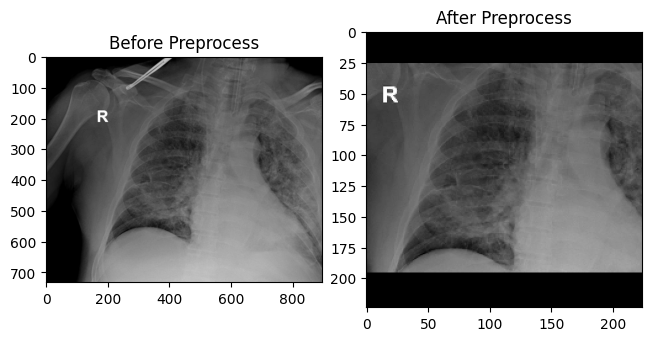

In [15]:
trial_image = Image.open(TRAIN_PATH + train[train.label == '1'].image.iloc[2])
changed_image = preprocess(trial_image)
print(changed_image.shape)
fig, ax = plt.subplots(1, 2, layout='constrained')
ax[0].imshow(trial_image, cmap='gray')
ax[0].set_title('Before Preprocess')
ax[1].imshow(changed_image, cmap='gray')
ax[1].set_title('After Preprocess')
plt.show()

## Model

Here we use the ImageDataGenerator class to create a training and validation set with a split of 75/25.

In [16]:
image_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0.25,
                               preprocessing_function=preprocess)

# obtaining training data
train_data = image_gen.flow_from_dataframe(
    dataframe=train,
    directory=TRAIN_PATH,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    subset='training',
    class_mode='binary',
    batch_size=10, 
    color_mode='grayscale',
    seed=21
)


# obtaining validation data
validate_data = image_gen.flow_from_dataframe(
    dataframe=train,
    directory=TRAIN_PATH,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    subset='validation',
    class_mode='binary',
    batch_size=5,
    color_mode='grayscale',
    seed=21
)

Found 136 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


(10, 224, 224, 1)


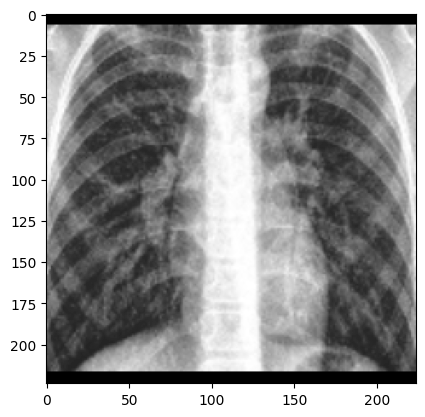

In [17]:
print(train_data[0][0].shape)
plt.imshow(train_data[0][0][6], cmap='gray')
plt.show()

Just to check, we see that the images are indeed the target size we set before and the image looks cropped showing the lungs.

Now is where we start to make the model structure for our convolutional neural network. The model is going to be based off the the already well-known architecture named VGG-19. We are going to try using the VGG-19 architecture because it did well classifying the ImageNet image set. It is also still widely used, so why not try a variation of it here. 

In the original VGG-19 there are 19 layers total, there is an initial 2 conv2d layer with 64 filters and kernel sizes of 3x3 and relu activation. It is then pooled using maxpool2d with size 2x2 and a stride of 2. Next is another 2 layer, very much the same as the previous 2 but with filters=128. That is 4 conv2d layers already, and now there is going to be 4 layers with filters of 256 and 3x3 kernel sizes with relu activation. The same pooling is done. The next four is going to be the same with a filter of 512. This is repeated another 4 times and then flatten and put into a 3 dense layers. In the original architecture, the dense layers had 4096, 4096 and 1000 units. For our model, we are going to be using 128, 128 and 1 since we don't have that much computational power in comparison and this is a binary classification.

We are then going to try the model 3 times with different learning rates. The first model is going to be a learning rate of 2e-5, then a learning rate of 2e-6 and finally something in between at 5e-6. The models are going to be trained over 15 epochs. Let's see how it does.

In [18]:
# creating model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(10, 224, 224, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (10, 224, 224, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (10, 224, 224, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (10, 112, 112, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (10, 112, 112, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (10, 112, 112, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (10, 56, 56, 128)        0         
 2D)                                                    

In [19]:
optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

In [20]:
model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy'])

In [21]:
history1 = model.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
14/14 [==============================] - 22s 920ms/step - loss: 0.6892 - accuracy: 0.6691 - val_loss: 0.7054 - val_accuracy: 0.4444
Epoch 2/15
14/14 [==============================] - 6s 432ms/step - loss: 0.6589 - accuracy: 0.6691 - val_loss: 0.7364 - val_accuracy: 0.4444
Epoch 3/15
14/14 [==============================] - 6s 445ms/step - loss: 0.6299 - accuracy: 0.6691 - val_loss: 0.7528 - val_accuracy: 0.4444
Epoch 4/15
14/14 [==============================] - 6s 458ms/step - loss: 0.5146 - accuracy: 0.7132 - val_loss: 0.3191 - val_accuracy: 0.9111
Epoch 5/15
14/14 [==============================] - 6s 432ms/step - loss: 0.2856 - accuracy: 0.8603 - val_loss: 0.2544 - val_accuracy: 0.9333
Epoch 6/15
14/14 [==============================] - 6s 430ms/step - loss: 0.3376 - accuracy: 0.8750 - val_loss: 0.6941 - val_accuracy: 0.5556
Epoch 7/15
14/14 [==============================] - 6s 439ms/step - loss: 0.1839 - accuracy: 0.9044 - val_loss: 0.2469 - val_accuracy: 0.9111
Epoch

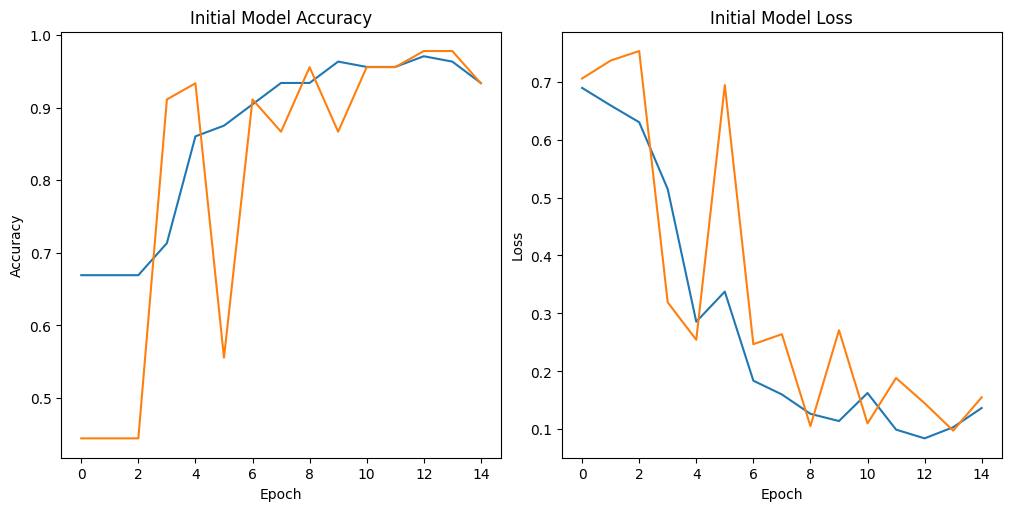

In [22]:
# plotting train/val accuracy and loss
fig, ax = plt.subplots(1, 2, sharex=True, layout='constrained', figsize=(10, 5))

ax[0].plot(history1.history['accuracy'], label='training')
ax[0].plot(history1.history['val_accuracy'], label='validation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Initial Model Accuracy')

ax[1].plot(history1.history['loss'], label='training')
ax[1].plot(history1.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Initial Model Loss')
plt.show()

The general trend looks to be that the model is reaching it's minimum point. Although I wish the descent/ascent would look smoother, it should be fine. 

In [23]:
# creating model 2 using the same architecture above
model2 = Sequential()

model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2))

model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2))

model2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2))

model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2))

model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

model2.build(input_shape=(10, 224, 224, 1))
model2.summary()

# the change is here with a learning rate of 2e-6
optimizer2 = tf.keras.optimizers.Adam(2e-6, beta_1=0.5)
model2.compile(optimizer=optimizer2, loss='BinaryCrossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (10, 224, 224, 64)        640       
                                                                 
 conv2d_17 (Conv2D)          (10, 224, 224, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (10, 112, 112, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (10, 112, 112, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (10, 112, 112, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (10, 56, 56, 128)        0         
 2D)                                                  

In [24]:
history2 = model2.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
14/14 [==============================] - 7s 438ms/step - loss: 0.6929 - accuracy: 0.6691 - val_loss: 0.6932 - val_accuracy: 0.4444
Epoch 2/15
14/14 [==============================] - 6s 432ms/step - loss: 0.6926 - accuracy: 0.6691 - val_loss: 0.6932 - val_accuracy: 0.4444
Epoch 3/15
14/14 [==============================] - 6s 433ms/step - loss: 0.6918 - accuracy: 0.6691 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 4/15
14/14 [==============================] - 6s 438ms/step - loss: 0.6897 - accuracy: 0.6691 - val_loss: 0.6941 - val_accuracy: 0.4444
Epoch 5/15
14/14 [==============================] - 6s 435ms/step - loss: 0.6840 - accuracy: 0.6691 - val_loss: 0.6971 - val_accuracy: 0.4444
Epoch 6/15
14/14 [==============================] - 6s 438ms/step - loss: 0.6691 - accuracy: 0.6691 - val_loss: 0.7088 - val_accuracy: 0.4444
Epoch 7/15
14/14 [==============================] - 6s 448ms/step - loss: 0.6460 - accuracy: 0.6691 - val_loss: 0.7279 - val_accuracy: 0.4444
Epoch 

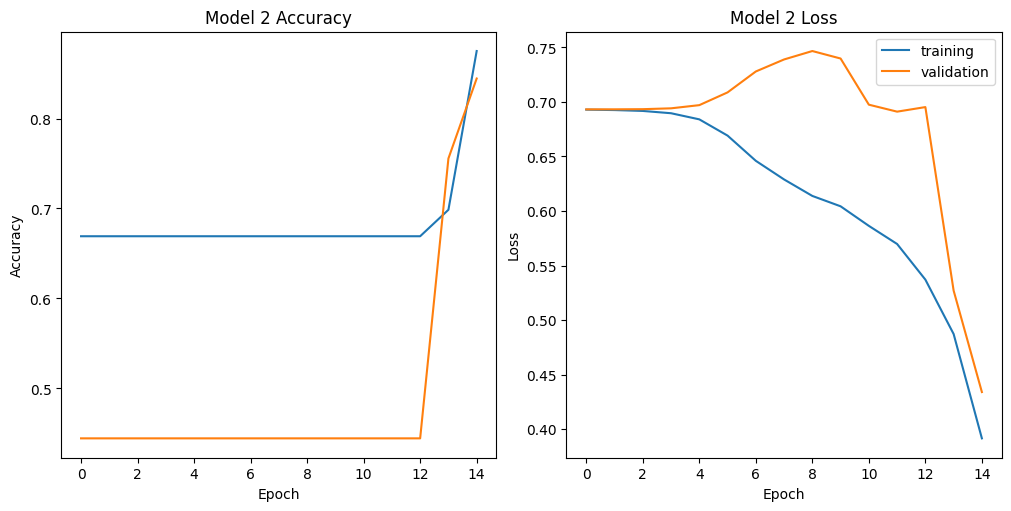

In [25]:
fig, ax = plt.subplots(1, 2, sharex=True, layout='constrained', figsize=(10, 5))

ax[0].plot(history2.history['accuracy'], label='training')
ax[0].plot(history2.history['val_accuracy'], label='validation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Model 2 Accuracy')

ax[1].plot(history2.history['loss'], label='training')
ax[1].plot(history2.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 2 Loss')
plt.show()

The model with a learning rate of 2e-6 looks to be a little too low for the number of training we have. It only began showing a run down a gradient at epochs 13 and 14 and has more space to learn.

In [26]:
# creating the final model with same structure
model3 = Sequential()

model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2))

model3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2))

model3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2))

model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2))

model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2))

model3.add(Flatten())
model3.add(Dense(units=128, activation='relu'))
model3.add(Dense(units=128, activation='relu'))
model3.add(Dense(units=1, activation='sigmoid'))

model3.build(input_shape=(10, 224, 224, 1))
model3.summary()

# the learning rate was changed to be some where between the two models above.
optimizer3 = tf.keras.optimizers.Adam(5e-6, beta_1=0.5)
model3.compile(optimizer=optimizer3, loss='BinaryCrossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (10, 224, 224, 64)        640       
                                                                 
 conv2d_33 (Conv2D)          (10, 224, 224, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (10, 112, 112, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (10, 112, 112, 128)       73856     
                                                                 
 conv2d_35 (Conv2D)          (10, 112, 112, 128)       147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (10, 56, 56, 128)        0         
 g2D)                                                 

In [27]:
history3 = model3.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
14/14 [==============================] - 7s 459ms/step - loss: 0.6930 - accuracy: 0.6103 - val_loss: 0.6931 - val_accuracy: 0.4444
Epoch 2/15
14/14 [==============================] - 6s 431ms/step - loss: 0.6920 - accuracy: 0.6691 - val_loss: 0.6933 - val_accuracy: 0.4444
Epoch 3/15
14/14 [==============================] - 6s 421ms/step - loss: 0.6832 - accuracy: 0.6691 - val_loss: 0.7015 - val_accuracy: 0.4444
Epoch 4/15
14/14 [==============================] - 6s 422ms/step - loss: 0.6349 - accuracy: 0.6691 - val_loss: 0.7684 - val_accuracy: 0.4444
Epoch 5/15
14/14 [==============================] - 6s 415ms/step - loss: 0.5939 - accuracy: 0.6691 - val_loss: 0.6965 - val_accuracy: 0.4444
Epoch 6/15
14/14 [==============================] - 6s 418ms/step - loss: 0.5195 - accuracy: 0.7206 - val_loss: 0.6357 - val_accuracy: 0.4667
Epoch 7/15
14/14 [==============================] - 6s 438ms/step - loss: 0.3146 - accuracy: 0.8971 - val_loss: 0.6603 - val_accuracy: 0.6222
Epoch 

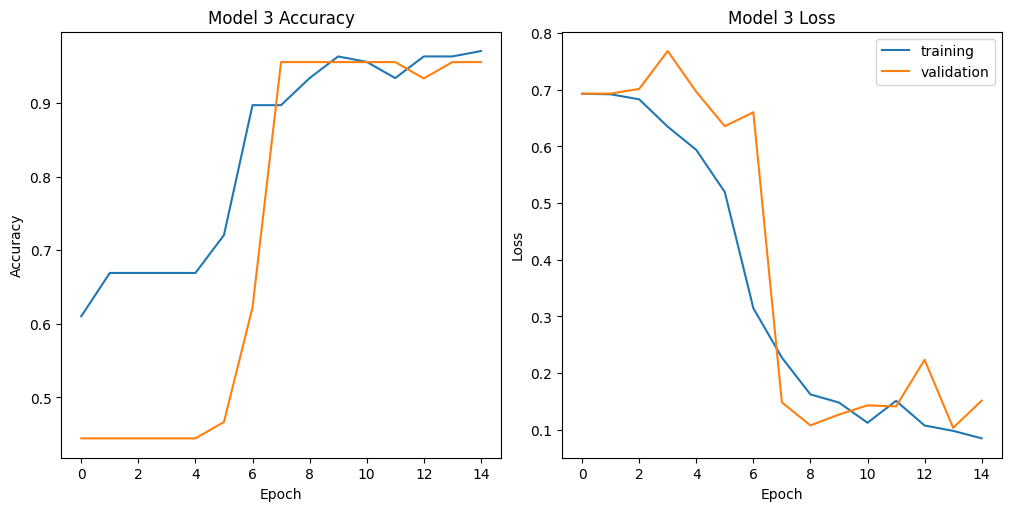

In [28]:
fig, ax = plt.subplots(1, 2, sharex=True, layout='constrained', figsize=(10, 5))

ax[0].plot(history3.history['accuracy'], label='training')
ax[0].plot(history3.history['val_accuracy'], label='validation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Model 3 Accuracy')

ax[1].plot(history3.history['loss'], label='training')
ax[1].plot(history3.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 3 Loss')
plt.show()

Finally, we have the last model with a learning rate of 5e-6. We see that it looks a little smoother compared to the initial model and looks to have reached a minimum since it's leveling off a litte in the accuracy plot and the loss plot.

## Results


It looks difficult to choose a specific model here so we are going to try the models against the test set. We have to remember that preprocess the same way for the test set just like the train set. 

In [80]:
image_gen = ImageDataGenerator(rescale=1./255.0, preprocessing_function=preprocess)

# obtaining testing data
test_data = image_gen.flow_from_dataframe(
    dataframe=test,
    directory=TEST_PATH,
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=1,
    color_mode='grayscale',
    seed=12
)

Found 46 validated image filenames.


In [81]:
pred1 = model.predict(test_data, verbose=1)
pred2 = model2.predict(test_data, verbose=1)
pred3 = model3.predict(test_data, verbose=1)

46/46 [==============================] - 1s 15ms/step


In [82]:
# reconfiguring the predictions and changing them into strings for the comparison
pred1 = np.transpose(pred1)[0]
pred1 = np.round(pred1).astype(int).astype(str)

pred2 = np.transpose(pred2)[0]
pred2 = np.round(pred2).astype(int).astype(str)

pred3 = np.transpose(pred3)[0]
pred3 = np.round(pred3).astype(int).astype(str)

In [83]:
np.asarray(test.label)

array(['1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1',
       '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1',
       '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '0'], dtype=object)

In [84]:
# compares the predictions with the true labels
# the sum function adds all the true comparisons (when 1=1 or 0=0 between the pred and actual)
# divide by 46 since thats the total number of items in the test set.
print('Model 1 Accuracy:',sum(pred1 == np.asarray(test.label)) / 46)
print('Model 2 Accuracy:',sum(pred2 == np.asarray(test.label)) / 46)
print('Model 3 Accuracy:',sum(pred3 == np.asarray(test.label)) / 46)

Model 1 Accuracy: 0.41304347826086957
Model 2 Accuracy: 0.5217391304347826
Model 3 Accuracy: 0.6521739130434783


We see that model 3, the model with a learning rate of 5e-6 has the best accuracy out of the 3 models for the test set.

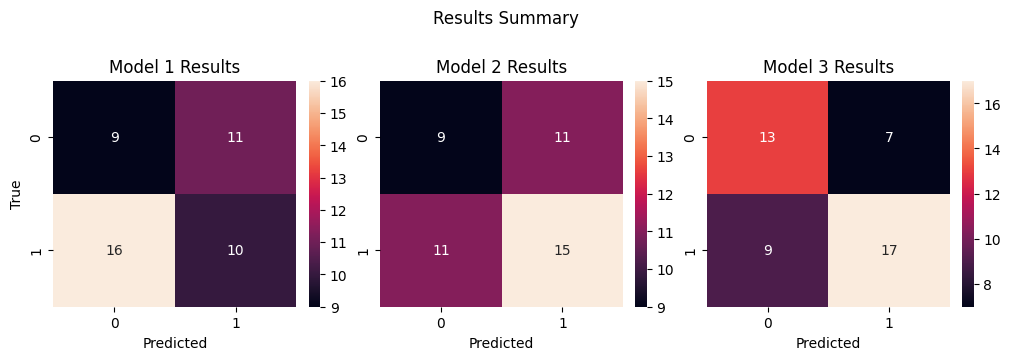

In [85]:
fig, ax = plt.subplots(1, 3, layout='constrained', figsize=(10, 3), sharex=True)
sns.heatmap(confusion_matrix(y_pred=pred1, y_true=np.asarray(test.label)), annot=True, ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Model 1 Results')
sns.heatmap(confusion_matrix(y_pred=pred2, y_true=np.asarray(test.label)), annot=True, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_title('Model 2 Results')
sns.heatmap(confusion_matrix(y_pred=pred3, y_true=np.asarray(test.label)), annot=True, ax=ax[2])
ax[2].set_xlabel('Predicted')
ax[2].set_title('Model 3 Results')

plt.suptitle('Results Summary', y=1.15)
plt.show()

Above, is the confusion matrix for the 3 models. The best model based on accuracy is model 3 with learning rate of 5e-6. In a health care setting, it is important to minimize false negatives because missing the presence of an illness is detrimental to the health of the patient moreso than a false negative. False negatives can be seen on the bottom left squares. We see that model 3 also has the lowest number of false negatives out of the 3. Therefore, we can conclude that the third model is going to be our best model.

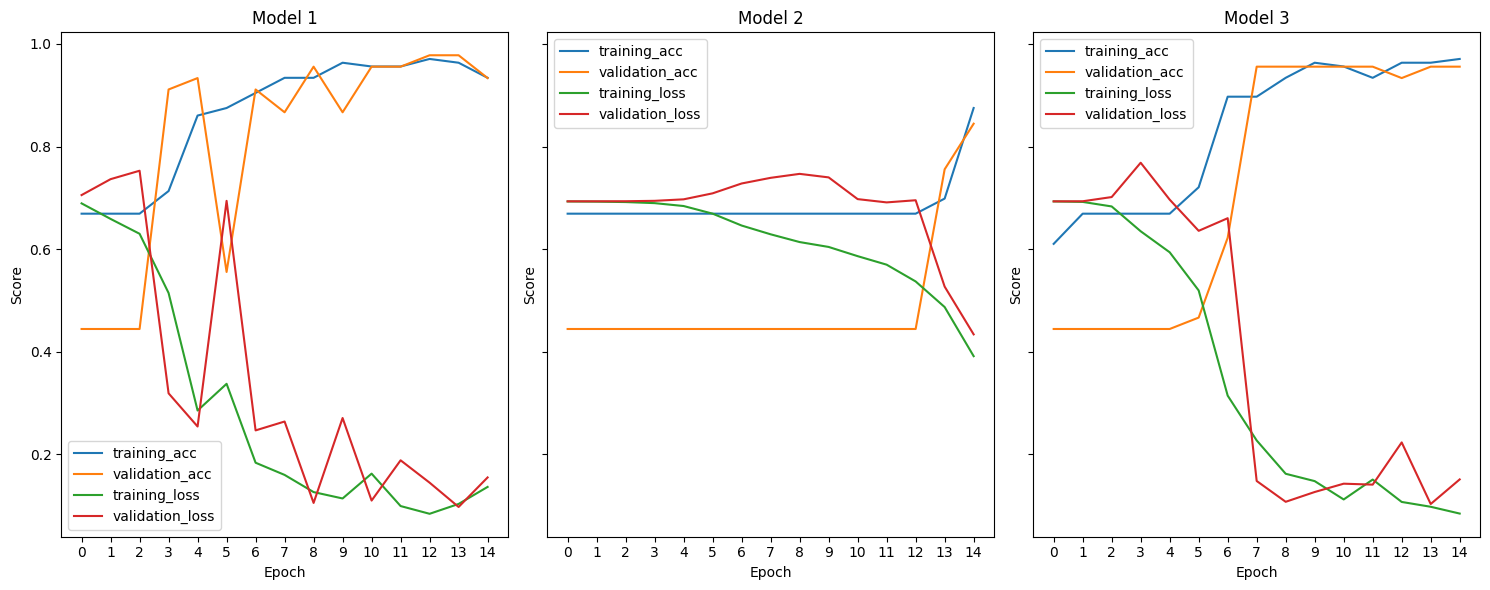

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)

axs[0].plot(history1.history['accuracy'], label='training_acc')
axs[0].plot(history1.history['val_accuracy'], label='validation_acc')
axs[0].plot(history1.history['loss'], label='training_loss')
axs[0].plot(history1.history['val_loss'], label='validation_loss')
axs[0].set_title('Model 1')
axs[0].legend()

axs[1].plot(history2.history['accuracy'], label='training_acc')
axs[1].plot(history2.history['val_accuracy'], label='validation_acc')
axs[1].plot(history2.history['loss'], label='training_loss')
axs[1].plot(history2.history['val_loss'], label='validation_loss')
axs[1].legend()
axs[1].set_title('Model 2')

axs[2].plot(history3.history['accuracy'], label='training_acc')
axs[2].plot(history3.history['val_accuracy'], label='validation_acc')
axs[2].plot(history3.history['loss'], label='training_loss')
axs[2].plot(history3.history['val_loss'], label='validation_loss')
axs[2].legend()
axs[2].set_title('Model 3')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Score')


plt.setp(axs, xticks=list(range(0, 15)), xticklabels=list(range(0, 15)))

plt.tight_layout()
plt.show()

Here is also the training and validation loss curves for all three models. Although model 2 is by far the smoother one out of the three, it hasn't reached its minimum yet. Whereas model 1 and 3 has but model 3 looks to be smoother in comparison.

## Discussion

By now, we see that although we based our model off the VGG-19 model structure, a well-known architecture that is able to classify things effectively, it did not work so well reaching a testing accuracy of around 65%. Why is that? Some reasons can be due to image inputs given to the model. In these models, the images were cropped by proportions since the images were not already the same size. Thinking back, these crops may be the cause because they may be cutting off some parts of the lungs if the lungs themselves were not centered and upright on the image. Instead if there was a way to scan the image and find the lungs themselves and then crop, the result should be a better, should. Another plausible reason is that the images themselves are hard to differentiate between COVID and normal lungs. Perhaps, some may look similar to each other and the lungs have not deteriorated in a manner that can be differentiated easily. Then there is a reason in the model itself. Perhaps it would have been wise to create a learning rate schedule where it starts off with a high lr and then decrease to several other lower lr's. This may help smoothen the curve and help the model learn more effectively.

We have listed some issues that may have resulted in such accuracy. For future studies perhaps we can try inputting an uncropped image and simply resizing them. Or we can figure out how to implement the solutions mentioned prior. We can also try to include the pneumonia images into the mix and try a multi-category classification as well. 

## Conclusion

Overall, we created a model based off the VGG-19 structure to try to classify x-ray images of lungs between normal lungs and lungs with COVID-19. Although the test accuracy was lower than we would have liked at an accuracy of 65%, there are some improvements that can be made for future works. COVID-19 is going to remain with us, most likely forever, just like the seasonal flu, so it's important to be able to diagnose it effectively in order to mitigate its damage on the population. 